# Analysis of the Attack on the data generated by LIME, and oversampled using SMOTENC

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from pathlib import Path
import os
import sys
import bz2
import pickle
np.random.seed(10)
# adds the visibility of the mlem module, needed to load the attack models
sys.path.append("../../../..") 
import mlem
from mlem.ensemble import HardVotingClassifier

In [2]:
import warnings

# Dataset Generated with LIME + OVERSAMPLING 

In [3]:
BLACK_BOX_PATH = './BB_DATA/adult_rf_noclustering.bz2'
EXPERIMENTS_RESULTS_FOLDER = "/home/gerardozinno/Desktop/ExperimentsResult/ADULT_OVERSAMPLING_GENERATED_DATASET/gaussian/gaussian"
BLACK_BOX_DATA_PATH = './BB_DATA/adult_rf_noclustering_data_nsamples_2.npz'
TRAIN_SET_CSV = 'BB_DATA/train.csv'
TEST_SET_CSV  = 'BB_DATA/test.csv'
NOISY_VALIDATION_SET_CSV = 'BB_DATA/validation_noisy.csv'
CENTROIDS_NEIGHBORS = 'BB_DATA/clusters_representatives_quantiles_2_48.csv'

In [4]:
def get_attack_mod(index:int, targets=[0,1], base_folder=EXPERIMENTS_RESULTS_FOLDER):
    """
    Args:
        index - row of the dataset on which the attack model was built
        targets (int | List(int)) - targets for the attack model.
    Returns:
        List containing the attack models (or model) for that particular index
    """
    if type(targets) is int:
        targets = [targets]
    loaded_models = []
    for t in targets:
        path = f"{base_folder}/{index}/attack/{t}/model.pkl.bz2"
        with bz2.BZ2File(path) as f:
            data = pickle.load(f)
            loaded_models.append(data)
    return loaded_models
        
def get_local_model(index:int, base_folder=EXPERIMENTS_RESULTS_FOLDER):
    """
    Args:
        index - row of the dataset on which the local model was built.
    Returns:
        Local model
    """
    path = f"{base_folder}/{index}/black_box"
    local_model_path = f"{path}/model.pkl.bz2"
    with bz2.BZ2File(local_model_path) as lm:
        local_model = pickle.load(lm)
    return local_model

def get_local_model_data(index: int, base_folder=EXPERIMENTS_RESULTS_FOLDER):
    """
    Args:
        index - row of the dataset on which the local model was built.
    Returns:
        Structure with keys x and y
    """
    path = f"{base_folder}/{index}/black_box"
    data_path = f"{path}/data.npz"
    loaded = np.load(data_path, allow_pickle=True)
    return loaded

#def get_subset_target_cluster(df, target, cluster):
#    """
#    Returns the subset of a dataframe with the specified target and cluster.
#    """
#    tmp = df[df['Target'] == target]
#    return tmp[tmp['Cluster'] == cluster]

def get_subset_cluster(df, cluster):
    """
    Returns the subset of a dataframe with the specified Cluster.
    """
    return df[df['Cluster'] == cluster]

def split_probs_array(arr):
    """
    
    """
    n_classes = len(arr[0])
    separated = []
    max_index_row = np.argmax(arr, axis=1)
    for c in range(n_classes):
        separated.append(arr[max_index_row == c])
    return separated

loading the data and the black box

In [5]:
with bz2.BZ2File(BLACK_BOX_PATH) as f:
    black_box = pickle.load(f)
black_box

RandomForestClassifier(max_depth=100, min_samples_leaf=10, min_samples_split=5,
                       n_estimators=350)

In [6]:
loaded = np.load(BLACK_BOX_DATA_PATH, allow_pickle=True)
for k in loaded.keys():
    print(k, end=" ")

x_train x_test y_train y_test x_test_clustered y_test_clustered 

In [7]:
x_train = loaded["x_train"]
x_test = loaded["x_test"]
y_train = loaded["y_train"]
y_test = loaded["y_test"]
x_test_clustered = loaded["x_test_clustered"]
y_test_clustered = loaded["y_test_clustered"]

In [8]:
feat_cols = [
    'Age', 'Workclass', 'Fnlwgt', 'Education', 'Education-num', 'Marital-status',
    'Occupation', 'Relationship', 'Race', 'Sex', 'Capital-gain', 'Capital-loss',
    'Hours-per-week', 'Native-country'
]
adult_train = pd.read_csv(TRAIN_SET_CSV)
adult_test = pd.read_csv(TEST_SET_CSV)
adult_test_subset_cluster = pd.read_csv(CENTROIDS_NEIGHBORS)

In [9]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

In [10]:
feat_cols = [
    'Age', 'Workclass', 'Fnlwgt', 'Education', 'Education-num', 'Marital-status',
    'Occupation', 'Relationship', 'Race', 'Sex', 'Capital-gain', 'Capital-loss',
    'Hours-per-week', 'Native-country'
]

#BASE_RESULTS_PATH = Path("ADA_ATTACK_RESULTS")
#BASE_RESULTS_PATH.mkdir(exist_ok=True)

# Attack with the Hard Voting Classifier

In [11]:
print(f"{len(x_test_clustered)=}")

len(x_test_clustered)=48


In [12]:
ATTACK_0, ATTACK_1 = [], []

for index in range(len(x_test_clustered)):
    atk0, atk1 = get_attack_mod(index)
    ATTACK_0.append(atk0)
    ATTACK_1.append(atk1)
assert (len(ATTACK_0) == len(ATTACK_1)) and (len(ATTACK_0) == len(x_test_clustered))
        
ensemble_0 = HardVotingClassifier(classifiers=ATTACK_0)
ensemble_1 = HardVotingClassifier(classifiers=ATTACK_1)

In [13]:
TRAIN = adult_train[feat_cols]
TEST = adult_test[feat_cols]

In [14]:
TRAIN_PREDICTIONS = black_box.predict_proba(TRAIN.to_numpy())
TEST_PREDICTIONS  = black_box.predict_proba(TEST.to_numpy())

In [15]:
TRAIN_PREDICTIONS_0 = TRAIN_PREDICTIONS[adult_train['Target'] == 0]
TRAIN_PREDICTIONS_1 = TRAIN_PREDICTIONS[adult_train['Target'] == 1]
TEST_PREDICTIONS_0 = TEST_PREDICTIONS[adult_test['Target'] == 0]
TEST_PREDICTIONS_1 = TEST_PREDICTIONS[adult_test['Target'] == 1]

In [16]:
IN_0 = ensemble_0.predict(TRAIN_PREDICTIONS_0)
IN_1 = ensemble_1.predict(TRAIN_PREDICTIONS_1)
OUT_0 = ensemble_0.predict(TEST_PREDICTIONS_0)
OUT_1 = ensemble_1.predict(TEST_PREDICTIONS_1)

In [17]:
INS = np.concatenate([IN_0, IN_1])
OUTS = np.concatenate([OUT_0, OUT_1])

In [18]:
number_outs = [x for x in OUTS if x == "out"]
number_even = [x for x in OUTS if x == "even"]
print(f"{len(number_outs)/len(OUTS)=}")
print(f"{len(number_even)/len(OUTS)=}")

len(number_outs)/len(OUTS)=0.13422726016035388
len(number_even)/len(OUTS)=0.0


In [19]:
INS_MASK = ['in'] * len(INS)
OUTS_MASK = ['out'] * len(OUTS)
INOUTS = np.concatenate([INS, OUTS])
EVEN_MASK = INOUTS != "even" # to mask away the even value

In [20]:
print(classification_report(np.array(INS_MASK + OUTS_MASK)[EVEN_MASK], INOUTS[EVEN_MASK]))

              precision    recall  f1-score   support

          in       0.70      0.88      0.78     16873
         out       0.32      0.13      0.19      7234

    accuracy                           0.66     24107
   macro avg       0.51      0.51      0.49     24107
weighted avg       0.59      0.66      0.60     24107



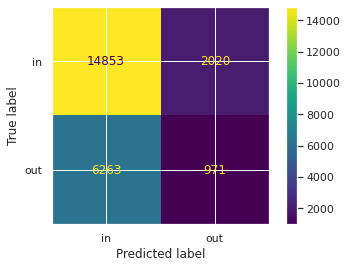

In [21]:
ConfusionMatrixDisplay.from_predictions(np.array(INS_MASK + OUTS_MASK)[EVEN_MASK], INOUTS[EVEN_MASK])

### Exploration of the Attack Models' data

In [22]:
from mlem.utilities import load_pickle_bz2

In [23]:
ATTACK_MODELS_DATA = []
for i in range(48):
    atk_path = Path(EXPERIMENTS_RESULTS_FOLDER) / str(i) / "attack"
    d = {}
    d["row"] = i
    for i in (0,1):
        atk_path_i = atk_path / str(i)
        d[i] = {}
        d[i]["data"] = np.load(atk_path_i / "data.npz", allow_pickle=True)
        d[i]["model"] = load_pickle_bz2(atk_path_i / "model.pkl.bz2")
    ATTACK_MODELS_DATA.append(d)

In [24]:
r0 = ATTACK_MODELS_DATA[0]

In [25]:
print(*r0[0]['data'].keys())

x_train x_test y_train y_test


In [26]:
a = pd.DataFrame(r0[0]['data']['y_test']).value_counts(normalize=True)

In [27]:
a

in     0.74993
out    0.25007
dtype: float64

In [28]:
for row in ATTACK_MODELS_DATA[:3]:
    s = f"row={row['row']}"
    
    train_test = None
    for atk in (0,1):
        mod_data = row[atk]['data']
        train_y = pd.DataFrame(mod_data['y_train']).value_counts()
        train_y_n = pd.DataFrame(mod_data['y_train']).value_counts(normalize=True)
        test_y = pd.DataFrame(mod_data['y_test']).value_counts()
        test_y_n = pd.DataFrame(mod_data['y_test']).value_counts(normalize=True)

        
        s += f"\n\t{atk=}:\n\t\ttrain in/out = {train_y['in']}/{train_y['out']} | {train_y_n['in']:.2f}/{train_y_n['out']:.2f}"
        s += f"\n\t\ttest  in/out = {test_y['in']}/{test_y['out']}  | {test_y_n['in']:.2f}/{test_y_n['out']:.2f}"
            
    print(s)
    

row=0
	atk=0:
		train in/out = 8070/2691 | 0.75/0.25
		test  in/out = 2690/897  | 0.75/0.25
	atk=1:
		train in/out = 8070/2691 | 0.75/0.25
		test  in/out = 2690/897  | 0.75/0.25
row=1
	atk=0:
		train in/out = 8151/2718 | 0.75/0.25
		test  in/out = 2717/906  | 0.75/0.25
	atk=1:
		train in/out = 8151/2718 | 0.75/0.25
		test  in/out = 2717/906  | 0.75/0.25
row=2
	atk=0:
		train in/out = 8070/2691 | 0.75/0.25
		test  in/out = 2690/897  | 0.75/0.25
	atk=1:
		train in/out = 8070/2691 | 0.75/0.25
		test  in/out = 2690/897  | 0.75/0.25


# PICK CENTROIDS LIME NEIGHBORHOOD

## No oversampling right after creation (on adult already left 5000+)

In [29]:
EXPERIMENTS_RESULTS_FOLDER = "/home/gerardozinno/Desktop/ExperimentsResult/ADULT_CENTROIDS_LIME_NO_OVERSAMPLING_AFTER_PICKING/gaussian/same"

In [30]:
ATTACK_0, ATTACK_1 = [], []

for index in range(len(x_test_clustered)):
    atk0, atk1 = get_attack_mod(index, base_folder=EXPERIMENTS_RESULTS_FOLDER)
    ATTACK_0.append(atk0)
    ATTACK_1.append(atk1)
assert (len(ATTACK_0) == len(ATTACK_1)) and (len(ATTACK_0) == len(x_test_clustered))
        
ensemble_0 = HardVotingClassifier(classifiers=ATTACK_0)
ensemble_1 = HardVotingClassifier(classifiers=ATTACK_1)

/home/gerardozinno/.pyenv/versions/ml-environment/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/gerardozinno/.pyenv/versions/ml-environment/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator AdaBoostClassifier from version 1.0.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [31]:
IN_0 = ensemble_0.predict(TRAIN_PREDICTIONS_0)
IN_1 = ensemble_1.predict(TRAIN_PREDICTIONS_1)
OUT_0 = ensemble_0.predict(TEST_PREDICTIONS_0)
OUT_1 = ensemble_1.predict(TEST_PREDICTIONS_1)

In [32]:
INS = np.concatenate([IN_0, IN_1])
OUTS = np.concatenate([OUT_0, OUT_1])

In [33]:
number_outs = [x for x in OUTS if x == "out"]
number_even = [x for x in OUTS if x == "even"]
print(f"{len(number_outs)/len(OUTS)=}")
print(f"{len(number_even)/len(OUTS)=}")

len(number_outs)/len(OUTS)=0.1392037600221178
len(number_even)/len(OUTS)=0.0


In [34]:
INS_MASK = ['in'] * len(INS)
OUTS_MASK = ['out'] * len(OUTS)
INOUTS = np.concatenate([INS, OUTS])
EVEN_MASK = INOUTS != "even" # to mask away the even value

In [35]:
print(classification_report(np.array(INS_MASK + OUTS_MASK)[EVEN_MASK], INOUTS[EVEN_MASK]))

              precision    recall  f1-score   support

          in       0.70      0.88      0.78     16877
         out       0.33      0.14      0.20      7234

    accuracy                           0.66     24111
   macro avg       0.51      0.51      0.49     24111
weighted avg       0.59      0.66      0.61     24111



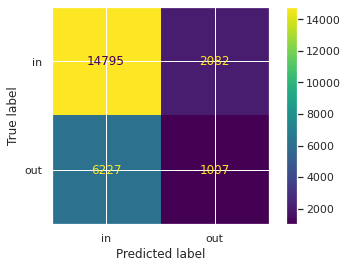

In [36]:
ConfusionMatrixDisplay.from_predictions(np.array(INS_MASK + OUTS_MASK)[EVEN_MASK], INOUTS[EVEN_MASK])

### Exploration of the Attack Models' data

In [37]:
ATTACK_MODELS_DATA = []
for i in range(48):
    atk_path = Path(EXPERIMENTS_RESULTS_FOLDER) / str(i) / "attack"
    d = {}
    d["row"] = i
    for i in (0,1):
        atk_path_i = atk_path / str(i)
        d[i] = {}
        d[i]["data"] = np.load(atk_path_i / "data.npz", allow_pickle=True)
        d[i]["model"] = load_pickle_bz2(atk_path_i / "model.pkl.bz2")
    ATTACK_MODELS_DATA.append(d)

for row in ATTACK_MODELS_DATA[:3]:
    s = f"row={row['row']}"
    
    train_test = None
    for atk in (0,1):
        mod_data = row[atk]['data']
        train_y = pd.DataFrame(mod_data['y_train']).value_counts()
        train_y_n = pd.DataFrame(mod_data['y_train']).value_counts(normalize=True)
        test_y = pd.DataFrame(mod_data['y_test']).value_counts()
        test_y_n = pd.DataFrame(mod_data['y_test']).value_counts(normalize=True)

        
        s += f"\n\t{atk=}:\n\t\ttrain in/out = {train_y['in']}/{train_y['out']} | {train_y_n['in']:.2f}/{train_y_n['out']:.2f}"
        s += f"\n\t\ttest  in/out = {test_y['in']}/{test_y['out']}  | {test_y_n['in']:.2f}/{test_y_n['out']:.2f}"
            
    print(s)

/home/gerardozinno/.pyenv/versions/ml-environment/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/gerardozinno/.pyenv/versions/ml-environment/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator AdaBoostClassifier from version 1.0.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


row=0
	atk=0:
		train in/out = 9393/174 | 0.98/0.02
		test  in/out = 3131/58  | 0.98/0.02
	atk=1:
		train in/out = 9393/3132 | 0.75/0.25
		test  in/out = 3131/1044  | 0.75/0.25
row=1
	atk=0:
		train in/out = 9146/175 | 0.98/0.02
		test  in/out = 3050/58  | 0.98/0.02
	atk=1:
		train in/out = 9147/3050 | 0.75/0.25
		test  in/out = 3049/1017  | 0.75/0.25
row=2
	atk=0:
		train in/out = 9345/177 | 0.98/0.02
		test  in/out = 3115/59  | 0.98/0.02
	atk=1:
		train in/out = 9345/3114 | 0.75/0.25
		test  in/out = 3115/1038  | 0.75/0.25


## With oversampling right after creation (bringing the proportion to 50/50)

In [38]:
EXPERIMENTS_RESULTS_FOLDER = "/home/gerardozinno/Desktop/ExperimentsResult/ADULT_CENTROIDS_LIME_WITH_OVERSAMPLING_AFTER_PICKING/gaussian/same"

In [39]:
ATTACK_0, ATTACK_1 = [], []

for index in range(len(x_test_clustered)):
    atk0, atk1 = get_attack_mod(index, base_folder=EXPERIMENTS_RESULTS_FOLDER)
    ATTACK_0.append(atk0)
    ATTACK_1.append(atk1)
assert (len(ATTACK_0) == len(ATTACK_1)) and (len(ATTACK_0) == len(x_test_clustered))
        
ensemble_0 = HardVotingClassifier(classifiers=ATTACK_0)
ensemble_1 = HardVotingClassifier(classifiers=ATTACK_1)

In [40]:
IN_0 = ensemble_0.predict(TRAIN_PREDICTIONS_0)
IN_1 = ensemble_1.predict(TRAIN_PREDICTIONS_1)
OUT_0 = ensemble_0.predict(TEST_PREDICTIONS_0)
OUT_1 = ensemble_1.predict(TEST_PREDICTIONS_1)

In [41]:
INS = np.concatenate([IN_0, IN_1])
OUTS = np.concatenate([OUT_0, OUT_1])

In [42]:
number_outs = [x for x in OUTS if x == "out"]
number_even = [x for x in OUTS if x == "even"]
print(f"{len(number_outs)/len(OUTS)=}")
print(f"{len(number_even)/len(OUTS)=}")

len(number_outs)/len(OUTS)=0.13961846834393143
len(number_even)/len(OUTS)=0.0


In [43]:
INS_MASK = ['in'] * len(INS)
OUTS_MASK = ['out'] * len(OUTS)
INOUTS = np.concatenate([INS, OUTS])
EVEN_MASK = INOUTS != "even" # to mask away the even value

In [44]:
print(classification_report(np.array(INS_MASK + OUTS_MASK)[EVEN_MASK], INOUTS[EVEN_MASK]))

              precision    recall  f1-score   support

          in       0.70      0.88      0.78     16875
         out       0.33      0.14      0.20      7234

    accuracy                           0.66     24109
   macro avg       0.51      0.51      0.49     24109
weighted avg       0.59      0.66      0.61     24109



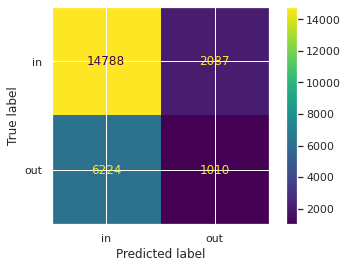

In [45]:
ConfusionMatrixDisplay.from_predictions(np.array(INS_MASK + OUTS_MASK)[EVEN_MASK], INOUTS[EVEN_MASK])

### Exploration of the Attack Models' data

In [46]:
ATTACK_MODELS_DATA = []
for i in range(48):
    atk_path = Path(EXPERIMENTS_RESULTS_FOLDER) / str(i) / "attack"
    d = {}
    d["row"] = i
    for i in (0,1):
        atk_path_i = atk_path / str(i)
        d[i] = {}
        d[i]["data"] = np.load(atk_path_i / "data.npz", allow_pickle=True)
        d[i]["model"] = load_pickle_bz2(atk_path_i / "model.pkl.bz2")
    ATTACK_MODELS_DATA.append(d)

for row in ATTACK_MODELS_DATA[:3]:
    s = f"row={row['row']}"
    
    train_test = None
    for atk in (0,1):
        mod_data = row[atk]['data']
        train_y = pd.DataFrame(mod_data['y_train']).value_counts()
        train_y_n = pd.DataFrame(mod_data['y_train']).value_counts(normalize=True)
        test_y = pd.DataFrame(mod_data['y_test']).value_counts()
        test_y_n = pd.DataFrame(mod_data['y_test']).value_counts(normalize=True)

        
        s += f"\n\t{atk=}:\n\t\ttrain in/out = {train_y['in']}/{train_y['out']} | {train_y_n['in']:.2f}/{train_y_n['out']:.2f}"
        s += f"\n\t\ttest  in/out = {test_y['in']}/{test_y['out']}  | {test_y_n['in']:.2f}/{test_y_n['out']:.2f}"
            
    print(s)

row=0
	atk=0:
		train in/out = 9393/3132 | 0.75/0.25
		test  in/out = 3131/1044  | 0.75/0.25
	atk=1:
		train in/out = 9393/3132 | 0.75/0.25
		test  in/out = 3131/1044  | 0.75/0.25
row=1
	atk=0:
		train in/out = 9147/3049 | 0.75/0.25
		test  in/out = 3049/1017  | 0.75/0.25
	atk=1:
		train in/out = 9147/3049 | 0.75/0.25
		test  in/out = 3049/1017  | 0.75/0.25
row=2
	atk=0:
		train in/out = 9345/3116 | 0.75/0.25
		test  in/out = 3115/1039  | 0.75/0.25
	atk=1:
		train in/out = 9344/3115 | 0.75/0.25
		test  in/out = 3116/1038  | 0.75/0.25
